I downloaded the reports from https://www.jpmorganchase.com/ir/annual-report,
The letters before the year of 2016 does not offer a website version. Thus I chose to download the pdfs and just start from there
To extract text, I tried pdfplumber, pypdf2 and pymupdf(fitz), and fitz worked the best among the 3.   

In [3]:
import os
import fitz

In [1]:
import flair

C:\ProgramData\Anaconda3\envs\newsmtsc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.Extract text from pdfs and save as report{year}.txt

In [17]:
filenames=os.listdir('source_pdfs/')
for filename in filenames:
    print(filename)
    final_name='source_pdfs/'+filename
    report= fitz.open(final_name)
    text_all=list()
    
    for page in report:
        txt=page.get_text()
        text_all.append(txt)
        
    text_all=''.join(text_all)
    digit_name=''.join(x for x in filename if x.isdigit())
    save_path=f"processed_txts/report{digit_name}.txt"
    with open(save_path, 'w',encoding="utf-8") as f:
        f.write(text_all)        

2013AR-Chairman-CEO-letter.pdf
ar2015-ceolettershareholders.pdf
ar2016-ceolettershareholders.pdf
ceo-letter-to-shareholders-2017.pdf
ceo-letter-to-shareholders-2018.pdf
ceo-letter-to-shareholders-2019.pdf
ceo-letter-to-shareholders-2020.pdf
ceo-letter-to-shareholders-2021.pdf
ceo-letter-to-shareholders-2022.pdf
JPMC-AR2014-LetterToShareholders.pdf


2. words cleaning   
remove line switch, unrecognizable punctuation, and "-", and split into sentences.  
 
No lemmatize nor stemmatize required, as both flair and newssentiment are pretrained LLM that do not require those precedure  

In [37]:
import cleantext

In [1]:
def textclean(filename):
    with open(filename, 'r+',encoding="utf-8") as f:
        text=f.read()   
        text=text.replace("-","")
        text=text.replace("\n"," ")
        text=text.replace('�'," ")
        text=text.replace('\uf06e','')
        text=text.replace('•','')
        text=text.split(' ')
        text=[i for i in text if (i!=''and i!='\uf03c')]
        sentences=list()
        sentence=list()
        temp_len=len(text)
        for i in range(temp_len):
            sentence.append(text[i])
            if (text[i].endswith('.') or text[i].endswith("?")) and (i+1==temp_len or text[i+1][0].isupper()):
                sentence=" ".join(i for i in sentence)
                #sentence=cleantext.clean(sentence)
                #use cleantext package to do this. url: https://github.com/prasanthg3/cleantext.  
                sentences.append(sentence)
                sentence=list()
    return sentences

In [2]:
reports=list()
for i in range(2013,2023):
    filename=f"processed_txts/report{str(i)}.txt"
    reports.append(textclean(filename))

3. overall sentiment score   
Calculate each year's sentiment as average of all sentences. Use flair bc it's based on pretrained LLM(distilBERT).   
Load the model for the first time could take a while. Save the results as they will be later used again

In [31]:
from flair.models import TextClassifier
from flair.data import Sentence
import dill

# load the model
classifier = TextClassifier.load('en-sentiment')
def predict(sentence):
    """ Predict the sentiment of a sentence """
    if sentence == "":
        return 0
    sentence = Sentence(sentence)
    classifier.predict(sentence)
  # Extract the score
    score = sentence.labels[0].score
    value = sentence.labels[0].value
    #if value=='NEUTRAL' :score=0
    if value=='NEGATIVE':score=0-score
  # Return the score and the predicted label
    return score

def sentiment_report(reports):
    '''save each sentence's sentiment in a list of dictionaries '''
    '''so that I can compare this with the result of NewsSentiment later'''
    
    count=0
    flair_sent=list()
    for report in reports:
        print(count)
        count+=1
        yr_sent=dict()
        for sentence in report:
            sent=predict(sentence)
            yr_sent[sentence]=sent
        flair_sent.append(yr_sent)
    return flair_sent

flair_sent= dill.load(open("flair_sent.pickle", "rb"))

'''unmark those if you want to fit the model again'''
#flair_sent=sentiment_report(reports)
#dill.dump(flair_sent, file = open("flair_sent.pickle", "wb"))


'unmark those if you want to fit the model again'

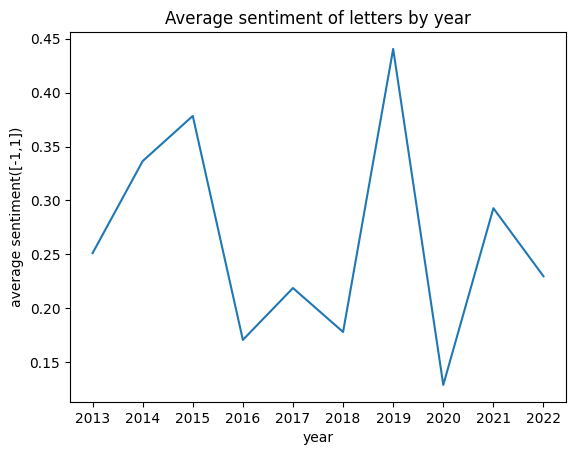

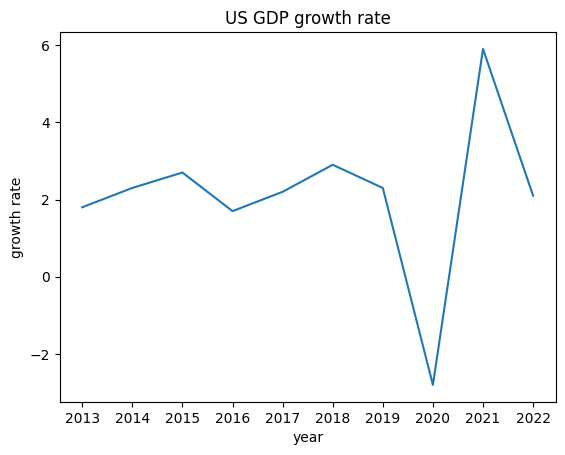

In [34]:
import statistics
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def calc_sent(flair_sent):
    avg_sent=list()
    for i in range(len(flair_sent)):
        res=statistics.mean(list(flair_sent[i].values()))
        avg_sent.append(res)
    return avg_sent
avg_sent=calc_sent(flair_sent)

#visualization
x = range(2013,2023)
plt.title('Average sentiment of letters by year')
plt.xlabel("year")
plt.ylabel('average sentiment([-1,1])')
plt.xticks(np.linspace(2013, 2023, 11))
plt.plot(x,avg_sent)
plt.show()

USGDP_Growth=[1.8,2.3,2.7,1.7,2.2,2.9,2.3,-2.8,5.9,2.1]
plt.title("US GDP growth rate")
plt.xlabel('year')
plt.ylabel('growth rate')
plt.xticks(np.linspace(2013, 2023, 11))
plt.plot(x,USGDP_Growth )
plt.show()

fig,ax1=plt.subplots()

4. topic analysis with TFIDF

In [35]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
report_split_words=list()
for i in range(len(reports)):
    report_temp=list()
    for sentence in reports[i]:
        sentence_temp=cleantext.clean_words(sentence,
                                            clean_all= False,# Execute all cleaning operations
                                            extra_spaces=True ,# Remove extra white spaces 
                                            stemming=False , # Stem the words
                                            stopwords=True ,# Remove stop words
                                            lowercase=True ,# Convert to lowercase
                                            numbers=True ,# Remove all digits 
                                            punct=True ,# Remove all punctuations
                                            stp_lang='english'  # Language for stop words
                                           )       
        report_temp+=sentence_temp
    report_temp=" ".join([i for i in report_temp if i!='\uf06e'])
    report_temp=report_temp.replace('jpmorgan chase','jpmorganchase')
    report_temp=report_temp.replace('us economy','useconomy')
    report_split_words.append(report_temp)

In [39]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(report_split_words)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

C:\ProgramData\Anaconda3\envs\newsmtsc\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [40]:
tfidf_score=list()
for i in range(10):
    temp_dict=dict()
    for j in range(len(feature_names)):
        temp_dict[feature_names[j]]=denselist[i][j]
    tfidf_score.append(temp_dict)

In [62]:
count=2013
frame=list()

for i in tfidf_score:
    frame.append(list(dict(sorted(i.items(), key=lambda item: item[1],reverse=True)[:10]).keys()))

In [63]:
print(frame)
#frame_df=pd.DataFrame.from_dict(frame)

[['new', 'capital', 'us', 'clients', 'business', 'bank', 'banks', 'assets', 'global', 'financial'], ['banks', 'business', 'bank', 'capital', 'crisis', 'clients', 'company', 'new', 'one', 'market'], ['banks', 'clients', 'us', 'new', 'bank', 'business', 'capital', 'people', 'many', 'one'], ['capital', 'bank', 'banks', 'would', 'business', 'growth', 'us', 'companies', 'many', 'new'], ['business', 'us', 'years', 'growth', 'people', 'bank', 'new', 'jpmorganchase', 'would', 'company'], ['many', 'us', 'banks', 'new', 'jpmorganchase', 'would', 'capital', 'business', 'growth', 'issues'], ['crisis', 'customers', 'us', 'bank', 'employees', 'businesses', 'one', 'jpmorganchase', 'business', 'clients'], ['us', 'covid', 'people', 'need', 'banks', 'many', 'new', 'capital', 'world', 'would'], ['need', 'us', 'banks', 'global', 'also', 'world', 'billion', 'people', 'company', 'capital'], ['banks', 'us', 'business', 'also', 'bank', 'company', 'economic', 'need', 'market', 'global']]


In [69]:
df_frame=pd.DataFrame(frame, columns=['1st', '2nd', '3rd', '4th', '5th',"6th",'7th','8th','9th','10th'])
df_frame.index=range(2013,2023)
df_frame

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
2013,new,capital,us,clients,business,bank,banks,assets,global,financial
2014,banks,business,bank,capital,crisis,clients,company,new,one,market
2015,banks,clients,us,new,bank,business,capital,people,many,one
2016,capital,bank,banks,would,business,growth,us,companies,many,new
2017,business,us,years,growth,people,bank,new,jpmorganchase,would,company
2018,many,us,banks,new,jpmorganchase,would,capital,business,growth,issues
2019,crisis,customers,us,bank,employees,businesses,one,jpmorganchase,business,clients
2020,us,covid,people,need,banks,many,new,capital,world,would
2021,need,us,banks,global,also,world,billion,people,company,capital
2022,banks,us,business,also,bank,company,economic,need,market,global


ok, without more detailed name entity and noun extraction it does not seem to give us much idea, except that bank, capital, crisis, bussiness, market, company, world, global can be targets.   
However, one thing notable is that covid appeared in the letter for 2020

4. sentiment with targeted noums
Noums including "economy" and those other keywords extracted, use NewsSentiment   
it claims to be the "best performing" TSC for news. check: https://pypi.org/project/NewsSentiment/

In [4]:
from NewsSentiment import TargetSentimentClassifier

C:\ProgramData\Anaconda3\envs\newsmtsc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [73]:
tsc = TargetSentimentClassifier()

def tsc_sent_calc(sentence,keyword):
    temp_len=len(keyword)
    start=sentence.index(keyword)
    end=start+temp_len
    before=sentence[:start]
    this=sentence[start:end]
    after=sentence[end:]
    sentiment=tsc.infer_from_text(before,this,after)
    if sentiment[0]['class_label']=='negative':return 0 - sentiment[0]['class_prob']
    elif sentiment[0]['class_label']=='neutral':return 0
    return sentiment[0]['class_prob']

def tsc_sentiment_report(reports,keyword):
    '''save each sentence's sentiment in a list of dictionaries '''
    '''so that I can compare this with the result of NewsSentiment later''' 
    tsc_sent=list()
    count=0
    for report in reports:
        print(count,end=" ")
        count+=1
        yr_sent=dict()
        for sentence in report:
            if keyword in sentence:
                try:
                    sent=tsc_sent_calc(sentence,keyword)
                except:
                    print(sentence)
                    continue
                yr_sent[sentence]=sent
        tsc_sent.append(yr_sent)
    return tsc_sent

def tsc_sentiment_driver(reports,keywords):
    tsc_sent_sup=dict()
    for keyword in keywords:
        print(f"searching:{keyword}")
        tsc_sent_sup[keyword]=tsc_sentiment_report(reports,keyword)
    return tsc_sent_sup
tsc_sent= dill.load(open("tsc_sent.pickle", "rb"))
#tsc_sent=tsc_sentiment_driver(reports,['economy','market','business',"JPMorgan","capital","U.S. economy","growth"]) 
#dill.dump(tsc_sent, file = open("tsc_sent.pickle", "wb"))

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statistics

def calc_sent(tsc_sent):
    avg_sent=list()
    for i in range(len(tsc_sent)):
        res=statistics.mean(list(tsc_sent[i].values()))
        avg_sent.append(res)
    return avg_sent

def visualize(keyword):#visualization
    x = range(2013,2023)
    plt.title(f'Average sentiment of {keyword} by year')
    plt.xlabel("year")
    plt.ylabel('average sentiment of([-1,1])')
    plt.xticks(np.linspace(2013, 2023, 11))
    plt.plot(x,calc_sent(tsc_sent[keyword]))
    
#for keyword in['economy','market','business',"JPMorgan","capital","growth"]:visualize(keyword)

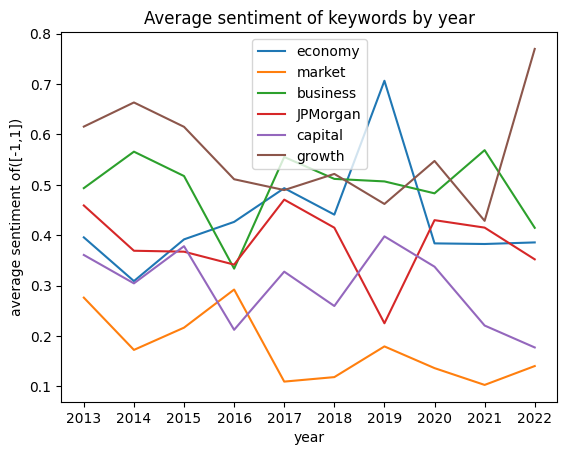

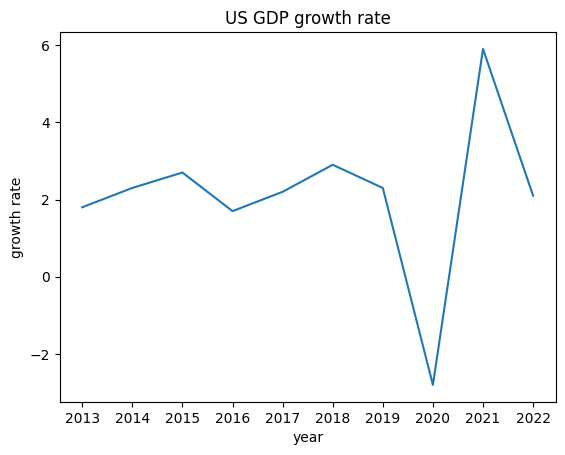

In [28]:
x = range(2013,2023)
plt.title(f'Average sentiment of keywords by year')
plt.xlabel("year")
plt.ylabel('average sentiment of([-1,1])')
plt.xticks(np.linspace(2013, 2023, 11))
for keyword in['economy','market','business',"JPMorgan","capital","growth"]: 
    plt.plot(x,calc_sent(tsc_sent[keyword]),label=keyword )
plt.legend()
plt.show()

USGDP_Growth=[1.8,2.3,2.7,1.7,2.2,2.9,2.3,-2.8,5.9,2.1]
plt.title("US GDP growth rate")
plt.xlabel('year')
plt.ylabel('growth rate')
plt.xticks(np.linspace(2013, 2023, 11))
plt.plot(x,USGDP_Growth )